Object found - 91 good matches


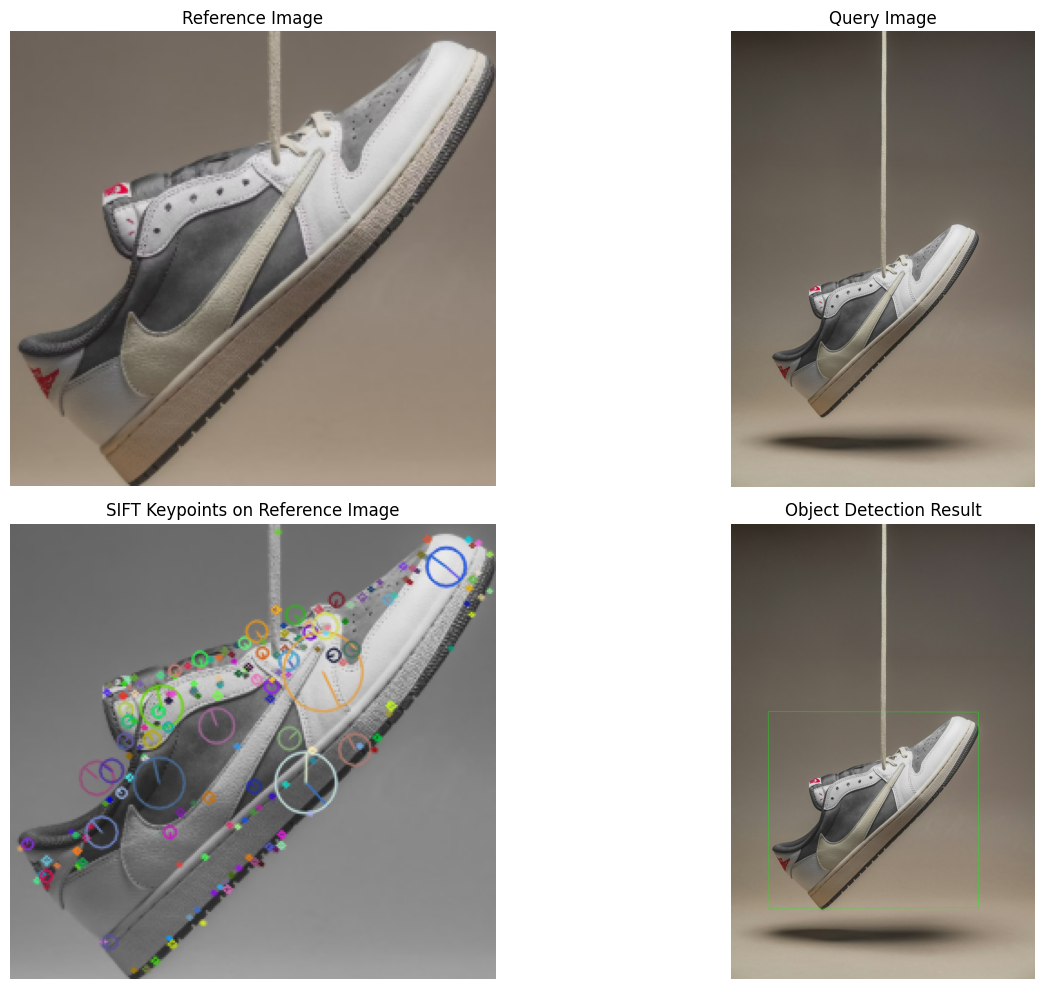

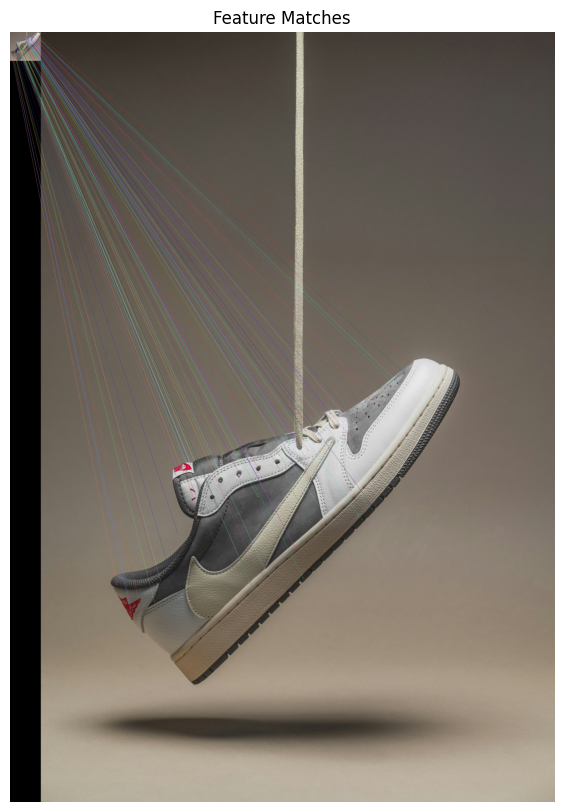

In [16]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def detect_and_match_objects(reference_image_path, query_image_path, min_match_count=10):
    Detect objects in a query image based on a reference image using SIFT features.

    Parameters:
    reference_image_path (str): Path to the reference image (object to be detected)
    query_image_path (str): Path to the query image (where to find the object)
    min_match_count (int): Minimum number of good matches required

    Returns:
    tuple: (result_image, homography_matrix, matches_mask)
    reference_img = cv2.imread(reference_image_path)
    query_img = cv2.imread(query_image_path)

    reference_gray = cv2.cvtColor(reference_img, cv2.COLOR_BGR2GRAY)
    query_gray = cv2.cvtColor(query_img, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()

    kp_reference, des_reference = sift.detectAndCompute(reference_gray, None)
    kp_query, des_query = sift.detectAndCompute(query_gray, None)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des_reference, des_query, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    matches_mask = [[0, 0] for _ in range(len(matches))]

    homography = None
    if len(good_matches) >= min_match_count:
        src_pts = np.float32([kp_reference[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp_query[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        homography, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)

        for i, (m, _) in enumerate(matches):
            if m in good_matches and mask[good_matches.index(m)]:
                matches_mask[i] = [1, 0]

        h, w = reference_gray.shape
        corners = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)
        transformed_corners = cv2.perspectiveTransform(corners, homography)

        result_img = query_img.copy()
        cv2.polylines(result_img, [np.int32(transformed_corners)], True, (0, 255, 0), 3)

        print(f"Object found - {len(good_matches)} good matches")
    else:
        print(f"Not enough matches found - {len(good_matches)}/{min_match_count}")
        result_img = query_img.copy()
        homography = None

    return result_img, homography, matches_mask

def visualize_keypoints(image_path):
    Visualize SIFT keypoints on an image

    Parameters:
    image_path (str): Path to the image

    Returns:
    numpy.ndarray: Image with keypoints drawn
    img = cv2.imread(image_path)
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()
    keypoints = sift.detect(gray, None)

    img_with_keypoints = cv2.drawKeypoints(gray, keypoints, None, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

    return img_with_keypoints

def visualize_matches(reference_image_path, query_image_path):
    Visualize matches between reference and query images

    Parameters:
    reference_image_path (str): Path to the reference image
    query_image_path (str): Path to the query image

    Returns:
    numpy.ndarray: Image showing matches
    reference_img = cv2.imread(reference_image_path)
    query_img = cv2.imread(query_image_path)

    reference_gray = cv2.cvtColor(reference_img, cv2.COLOR_BGR2GRAY)
    query_gray = cv2.cvtColor(query_img, cv2.COLOR_BGR2GRAY)

    sift = cv2.SIFT_create()

    kp_reference, des_reference = sift.detectAndCompute(reference_gray, None)
    kp_query, des_query = sift.detectAndCompute(query_gray, None)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)

    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des_reference, des_query, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    img_matches = cv2.drawMatches(reference_img, kp_reference, query_img, kp_query, good_matches, None,
                                  flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)

    return img_matches

if __name__ == "__main__":
    reference_image = "ref.png"
    query_image = "shoe.jpg"

    result, homography, matches_mask = detect_and_match_objects(reference_image, query_image)

    result_rgb = cv2.cvtColor(result, cv2.COLOR_BGR2RGB)

    reference_keypoints = visualize_keypoints(reference_image)
    reference_keypoints_rgb = cv2.cvtColor(reference_keypoints, cv2.COLOR_BGR2RGB)

    matches_visualization = visualize_matches(reference_image, query_image)
    matches_visualization_rgb = cv2.cvtColor(matches_visualization, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(15, 10))

    plt.subplot(2, 2, 1)
    plt.imshow(cv2.cvtColor(cv2.imread(reference_image), cv2.COLOR_BGR2RGB))
    plt.title('Reference Image')
    plt.axis('off')

    plt.subplot(2, 2, 2)
    plt.imshow(cv2.cvtColor(cv2.imread(query_image), cv2.COLOR_BGR2RGB))
    plt.title('Query Image')
    plt.axis('off')

    plt.subplot(2, 2, 3)
    plt.imshow(reference_keypoints_rgb)
    plt.title('SIFT Keypoints on Reference Image')
    plt.axis('off')

    plt.subplot(2, 2, 4)
    plt.imshow(result_rgb)
    plt.title('Object Detection Result')
    plt.axis('off')

    plt.tight_layout()
    plt.show()

    plt.figure(figsize=(15, 10))
    plt.imshow(matches_visualization_rgb)
    plt.title('Feature Matches')
    plt.axis('off')
    plt.show()

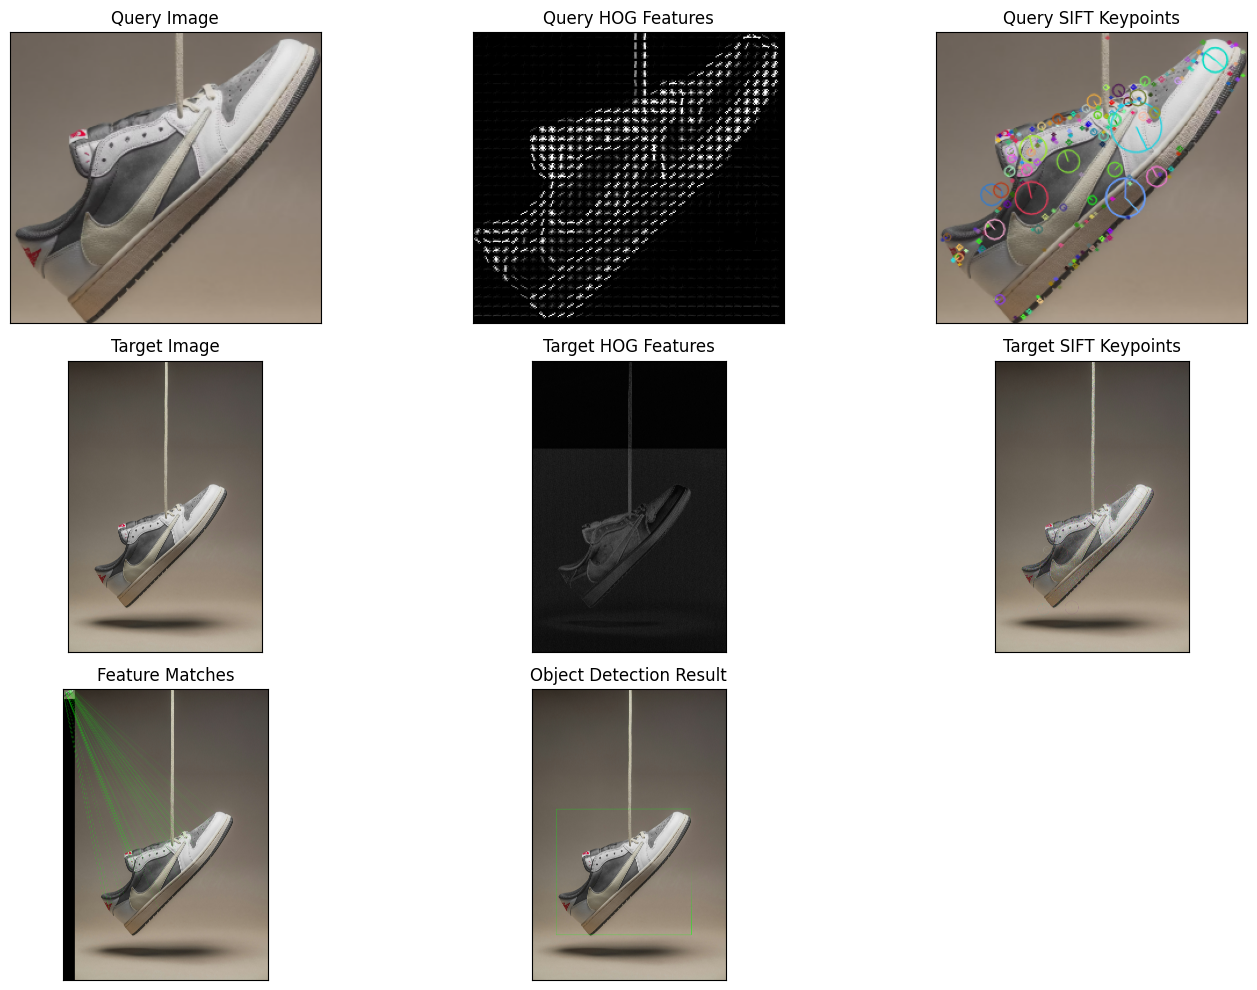

Number of SIFT keypoints in query image: 206
Number of SIFT keypoints in target image: 53823
Number of GLOH descriptors in query image: 180
Number of GLOH descriptors in target image: 53816
Object successfully detected in target image!


In [17]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from skimage.feature import hog
from skimage import exposure
from scipy import ndimage

def compute_sift_features(image):
    Compute SIFT features for the given image
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    sift = cv2.SIFT_create()

    keypoints, descriptors = sift.detectAndCompute(gray, None)

    return keypoints, descriptors

def compute_hog_features(image, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2)):
    Compute HOG features for the given image
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    hog_features, hog_image = hog(
        gray,
        orientations=orientations,
        pixels_per_cell=pixels_per_cell,
        cells_per_block=cells_per_block,
        visualize=True,
        block_norm='L2-Hys'
    )

    hog_image_rescaled = exposure.rescale_intensity(hog_image, in_range=(0, 10))

    return hog_features, hog_image_rescaled

def compute_gloh_features(image, keypoints):
    Compute GLOH features for the given image and keypoints
    GLOH is an extension of SIFT that uses a log-polar location grid with 3 bins in radial
    direction and 8 in angular direction, giving 17 location bins (including the central bin)
    if len(image.shape) == 3:
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    else:
        gray = image

    gloh_descriptors = []

    num_radial_bins = 3
    num_angular_bins = 8
    num_orientation_bins = 8
    radius_max = 20  # Maximum radius of the descriptor region

    for kp in keypoints:
        x, y = int(kp.pt[0]), int(kp.pt[1])
        scale = kp.size
        orientation = kp.angle

        if x < radius_max or y < radius_max or x >= gray.shape[1] - radius_max or y >= gray.shape[0] - radius_max:
            continue

        patch = gray[y-radius_max:y+radius_max, x-radius_max:x+radius_max]

        dx = ndimage.sobel(patch, axis=1)
        dy = ndimage.sobel(patch, axis=0)

        magnitude = np.sqrt(dx**2 + dy**2)
        orientation_map = np.arctan2(dy, dx) * 180 / np.pi % 360

        y_grid, x_grid = np.ogrid[-radius_max:radius_max, -radius_max:radius_max]
        r_grid = np.sqrt(x_grid**2 + y_grid**2)
        theta_grid = (np.arctan2(y_grid, x_grid) * 180 / np.pi) % 360

        radial_bins = np.zeros(num_radial_bins + 1)
        radial_bins[0] = 0
        radial_bins[1] = radius_max / 3
        radial_bins[2] = radius_max * 2 / 3
        radial_bins[3] = radius_max

        descriptor = np.zeros((1 + num_radial_bins * num_angular_bins) * num_orientation_bins)

        central_mask = r_grid < radial_bins[1]
        for o in range(num_orientation_bins):
            orient_min = o * 360 / num_orientation_bins
            orient_max = (o + 1) * 360 / num_orientation_bins
            orient_mask = (orientation_map >= orient_min) & (orientation_map < orient_max)
            mask = central_mask & orient_mask
            descriptor[o] = np.sum(magnitude[mask])

        descriptor_idx = num_orientation_bins
        for r in range(1, num_radial_bins):
            radial_mask = (r_grid >= radial_bins[r]) & (r_grid < radial_bins[r+1])
            for a in range(num_angular_bins):
                angle_min = a * 360 / num_angular_bins
                angle_max = (a + 1) * 360 / num_angular_bins
                angle_mask = (theta_grid >= angle_min) & (theta_grid < angle_max)
                for o in range(num_orientation_bins):
                    orient_min = o * 360 / num_orientation_bins
                    orient_max = (o + 1) * 360 / num_orientation_bins
                    orient_mask = (orientation_map >= orient_min) & (orientation_map < orient_max)
                    mask = radial_mask & angle_mask & orient_mask
                    descriptor[descriptor_idx] = np.sum(magnitude[mask])
                    descriptor_idx += 1

        norm = np.linalg.norm(descriptor)
        if norm > 0:
            descriptor /= norm

        gloh_descriptors.append(descriptor)

    return np.array(gloh_descriptors) if gloh_descriptors else None

def detect_objects(query_image, target_image, min_match_count=10):
    Detect objects in target image using features from query image
    kp1, des1 = compute_sift_features(query_image)

    kp2, des2 = compute_sift_features(target_image)

    FLANN_INDEX_KDTREE = 1
    index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
    search_params = dict(checks=50)
    flann = cv2.FlannBasedMatcher(index_params, search_params)

    matches = flann.knnMatch(des1, des2, k=2)

    good_matches = []
    for m, n in matches:
        if m.distance < 0.7 * n.distance:
            good_matches.append(m)

    if len(good_matches) >= min_match_count:
        src_pts = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1, 1, 2)
        dst_pts = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1, 1, 2)

        M, mask = cv2.findHomography(src_pts, dst_pts, cv2.RANSAC, 5.0)
        matchesMask = mask.ravel().tolist()

        h, w = query_image.shape[:2]
        pts = np.float32([[0, 0], [0, h-1], [w-1, h-1], [w-1, 0]]).reshape(-1, 1, 2)

        dst = cv2.perspectiveTransform(pts, M)

        result_image = target_image.copy()
        cv2.polylines(result_image, [np.int32(dst)], True, (0, 255, 0), 3, cv2.LINE_AA)

        draw_params = dict(
            matchColor=(0, 255, 0),  # Green color for matches
            singlePointColor=None,
            matchesMask=matchesMask,  # Only draw matched keypoints
            flags=2
        )

        match_image = cv2.drawMatches(query_image, kp1, target_image, kp2, good_matches, None, **draw_params)

        return True, result_image, match_image
    else:
        print("Not enough good matches: {}/{}".format(len(good_matches), min_match_count))
        return False, target_image, None

def main():
    query_image = cv2.imread('ref.png')
    target_image = cv2.imread('shoe.jpg')

    if query_image is None or target_image is None:
        print("Error: Could not load one or both images")
        return

    success, result_image, match_image = detect_objects(query_image, target_image)

    _, hog_image_query = compute_hog_features(query_image)
    _, hog_image_target = compute_hog_features(target_image)

    keypoints_query, _ = compute_sift_features(query_image)
    keypoints_target, _ = compute_sift_features(target_image)

    gloh_descriptors_query = compute_gloh_features(query_image, keypoints_query)
    gloh_descriptors_target = compute_gloh_features(target_image, keypoints_target)

    sift_image_query = cv2.drawKeypoints(
        query_image,
        keypoints_query,
        None,
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )

    sift_image_target = cv2.drawKeypoints(
        target_image,
        keypoints_target,
        None,
        flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS
    )

    plt.figure(figsize=(15, 10))

    plt.subplot(331), plt.imshow(cv2.cvtColor(query_image, cv2.COLOR_BGR2RGB))
    plt.title('Query Image'), plt.xticks([]), plt.yticks([])

    plt.subplot(332), plt.imshow(hog_image_query, cmap='gray')
    plt.title('Query HOG Features'), plt.xticks([]), plt.yticks([])

    plt.subplot(333), plt.imshow(cv2.cvtColor(sift_image_query, cv2.COLOR_BGR2RGB))
    plt.title('Query SIFT Keypoints'), plt.xticks([]), plt.yticks([])

    plt.subplot(334), plt.imshow(cv2.cvtColor(target_image, cv2.COLOR_BGR2RGB))
    plt.title('Target Image'), plt.xticks([]), plt.yticks([])

    plt.subplot(335), plt.imshow(hog_image_target, cmap='gray')
    plt.title('Target HOG Features'), plt.xticks([]), plt.yticks([])

    plt.subplot(336), plt.imshow(cv2.cvtColor(sift_image_target, cv2.COLOR_BGR2RGB))
    plt.title('Target SIFT Keypoints'), plt.xticks([]), plt.yticks([])

    if success:
        plt.subplot(337), plt.imshow(cv2.cvtColor(match_image, cv2.COLOR_BGR2RGB))
        plt.title('Feature Matches'), plt.xticks([]), plt.yticks([])

        plt.subplot(338), plt.imshow(cv2.cvtColor(result_image, cv2.COLOR_BGR2RGB))
        plt.title('Object Detection Result'), plt.xticks([]), plt.yticks([])

    plt.tight_layout()
    plt.show()

    print(f"Number of SIFT keypoints in query image: {len(keypoints_query)}")
    print(f"Number of SIFT keypoints in target image: {len(keypoints_target)}")

    if gloh_descriptors_query is not None:
        print(f"Number of GLOH descriptors in query image: {len(gloh_descriptors_query)}")

    if gloh_descriptors_target is not None:
        print(f"Number of GLOH descriptors in target image: {len(gloh_descriptors_target)}")

    if success:
        print("Object successfully detected in target image!")
    else:
        print("Object detection failed.")

if __name__ == "__main__":
    main()

In [18]:
import numpy as np
import cv2
import os
import glob
import matplotlib.pyplot as plt
from skimage.feature import hog
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

def load_images_from_folder(folder, label):
    images = []
    labels = []
    for filename in glob.glob(os.path.join(folder, "*.jpg")):  # Adjust extension if needed
        img = cv2.imread(filename, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
        if img is not None:
            img = cv2.resize(img, (64, 64))  # Resize to a fixed size
            images.append(img)
            labels.append(label)
    return images, labels

cat_images, cat_labels = load_images_from_folder("drive/MyDrive/Datasets/catsAndDogs40/train/cat", label=0)
dog_images, dog_labels = load_images_from_folder("drive/MyDrive/Datasets/catsAndDogs40/train/dog", label=1)

X = np.array(cat_images + dog_images)
y = np.array(cat_labels + dog_labels)

hog_features = []
for image in X:
    feature, _ = hog(image, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=True)
    hog_features.append(feature)

X_hog = np.array(hog_features)

X_train, X_test, y_train, y_test = train_test_split(X_hog, y, test_size=0.2, random_state=42)

svm_model = SVC(kernel='linear')
svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)

accuracy = accuracy_score(y_test, y_pred)
print("Model Accuracy:", accuracy)
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Model Accuracy: 0.6153846153846154

Classification Report:
               precision    recall  f1-score   support

           0       0.67      0.33      0.44         6
           1       0.60      0.86      0.71         7

    accuracy                           0.62        13
   macro avg       0.63      0.60      0.58        13
weighted avg       0.63      0.62      0.59        13



Prediction: Cat


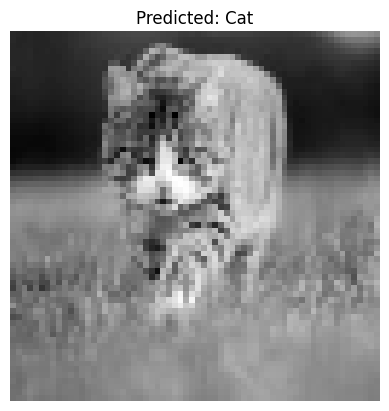

In [22]:
def predict_image(image_path, model):
    img = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)  # Convert to grayscale
    img = cv2.resize(img, (64, 64))  # Resize to match training data
    feature = hog(img, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False).reshape(1, -1)
    prediction = model.predict(feature)
    label = "Cat" if prediction[0] == 0 else "Dog"
    print(f"Prediction: {label}")

    plt.imshow(img, cmap='gray')
    plt.title(f"Predicted: {label}")
    plt.axis('off')
    plt.show()

predict_image("drive/MyDrive/Datasets/catsAndDogs40/test/cat/4.jpg", svm_model)